In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from imgaug import augmenters as iaa
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

train_paths = glob('/content/gdrive/My Drive/ImagesCV/*/*.*[!txt]')

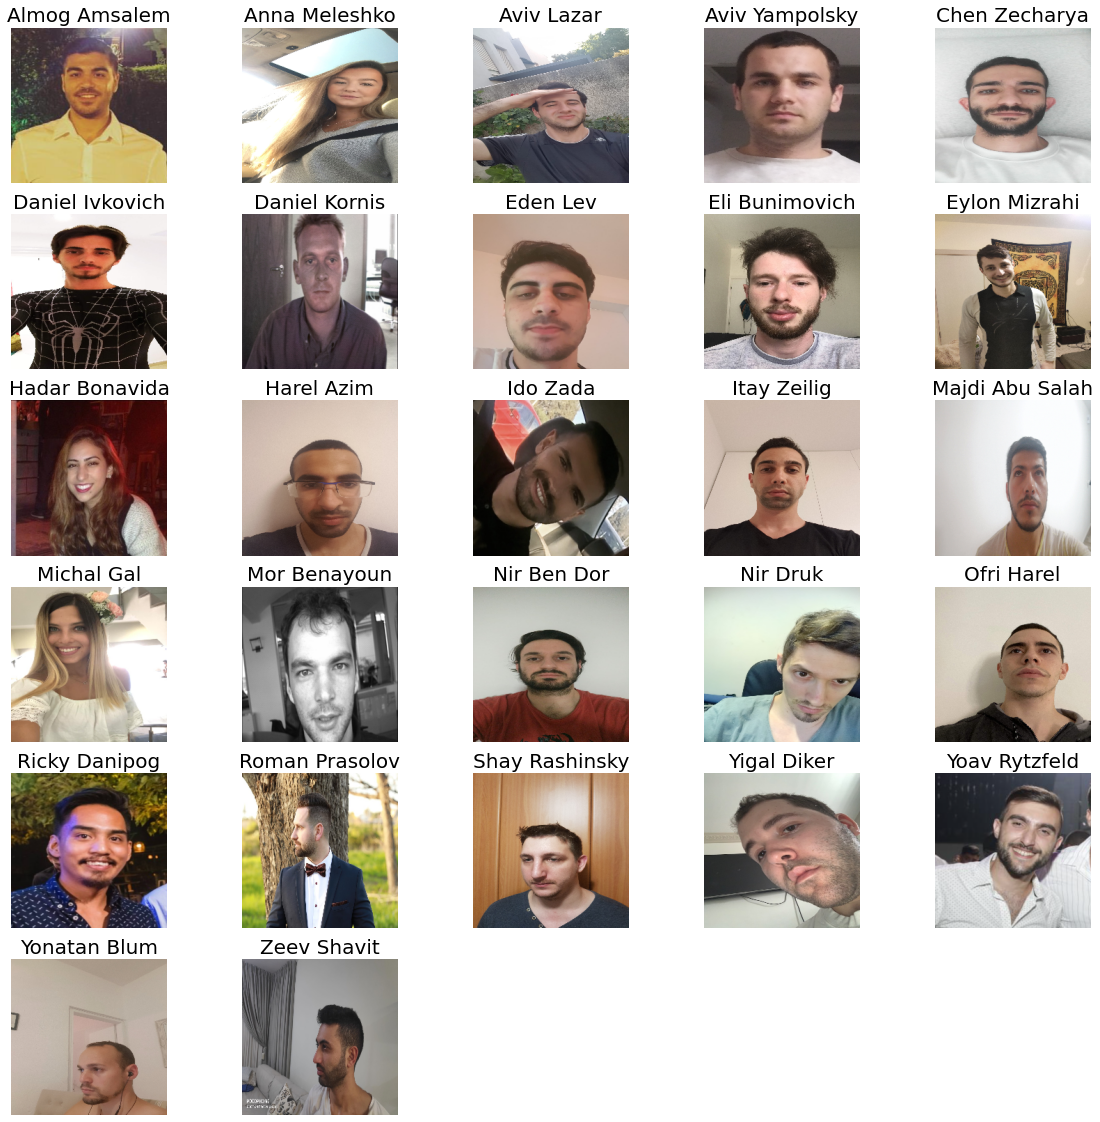

In [0]:
names = np.unique([path.split('/')[-2] for path in train_paths])
plt.figure(figsize=[20, 20])

for i, name in enumerate(names):
    for path in train_paths:
        if name in path:
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224), cv2.INTER_AREA)
            plt.subplot(6, 5, i+1)
            plt.imshow(img)
            name = " ".join(name.split('_'))
            plt.title(name, fontsize=20)
            plt.axis('off')
            break
plt.show()
            



In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq = iaa.Sequential([
                #   blur
                      sometimes(iaa.OneOf([
                                           iaa.GaussianBlur(sigma=2.0),
                                           iaa.AverageBlur(k=(2, 7)),
                                           iaa.MedianBlur(k=(3, 7)),
                                           iaa.JpegCompression(compression=(70, 99)),
                                           iaa.BilateralBlur(d=(3, 10), sigma_color=(10, 250),
                                                             sigma_space=(10, 250))])),
                    #   color
                      sometimes(iaa.OneOf([
                                           iaa.Add((-40, 40)),
                                           iaa.Add((-40, 40), per_channel=0.5),
                                           iaa.ChannelShuffle(0.35),
                                           iaa.Multiply((0.5, 1.5)),
                                           iaa.Multiply((0.5, 1.5), per_channel=0.5),
                                           iaa.MultiplyElementwise((0.5, 1.5)),
                                           iaa.Invert(0.5),
                                           iaa.Invert(0.25, per_channel=0.5)])),
                    # noise
                      sometimes(iaa.OneOf([
                                           iaa.AddElementwise((-40, 40)),
                                           iaa.AddElementwise((-40, 40), per_channel=0.5),
                                           iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                                           iaa.AdditiveGaussianNoise(scale=0.2*255, per_channel=True),
                                           iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255)),
                                           iaa.AdditiveLaplaceNoise(scale=0.2*255, per_channel=True),
                                           iaa.AdditivePoissonNoise(lam=(0, 40)),
                                           iaa.AdditivePoissonNoise(lam=40, per_channel=True)])),
                        # omitted
                     sometimes(iaa.OneOf([
                                           iaa.Dropout(p=(0, 0.2)),
                                           iaa.Dropout(p=(0, 0.2), per_channel=0.5),
                                           iaa.CoarseDropout(0.02, size_percent=0.5),
                                           iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),
                                           iaa.CoarseDropout(0.02, size_percent=0.15, per_channel=0.5),
                                           iaa.ReplaceElementwise(0.1, [0, 255]),
                                           iaa.ReplaceElementwise(0.1, [0, 255], per_channel=0.5),
                                           iaa.SaltAndPepper(0.1)])),
                    # geometric
                     sometimes(iaa.OneOf([
                                           iaa.Affine(scale={"x": (0.5, 1.5), "y": (0.5, 1.5)}),
                                           iaa.Affine(shear=(-10, 10)),
                                           iaa.ElasticTransformation(alpha=(0, 10), sigma=10),
                                           iaa.PiecewiseAffine(scale=(0.01, 0.05)),
                                           iaa.PerspectiveTransform(scale=(0.01, 0.15), keep_size=True),
                                           iaa.Rot90((1, 3))]))], random_order=True)


In [0]:
class student_dataset(Dataset):
        def __init__(self, paths, augmentations=None, transform=None, size=224):
            super(student_dataset, self).__init__()
            self.paths = paths
            self.augmentations = augmentations
            self.size = size
            self.transform = transform

        def __getitem__(self, idx):
            img, label = self.get_image(idx)
            if self.augmentations:
                img = self.augmentations.augment_image(img)
            if self.transform:
                img = transforms.ToPILImage()(img)
                img = self.transform(img)

            return img, label

        def __len__(self):
            return len(self.paths)

        def get_image(self, idx):
            path = self.paths[idx]
            label = path.split('/')[-2]
            label = " ".join(label.split('_'))
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.size, self.size), cv2.INTER_AREA)  
            return img, label



In [0]:
BS = 16

transform = torchvision.transforms.Compose([ 
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_paths, test_paths = train_test_split(train_paths, test_size=0.1, random_state=2018)

trainset = student_dataset(train_paths, augmentations=seq, transform=transform)
train_loader = DataLoader(trainset, batch_size=BS, shuffle=True, num_workers=4)
print(len(train_paths), len(test_paths))




501 56


# show all student

In [0]:
def norm(img):
    img -=img.min()
    img/=img.max()
    return img

def show_aug(augmentations, title, batch_size=8):
    trainset = student_dataset(train_paths, augmentations=augmentations, transform=transform)
    dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    batch = iter(dataloader)
    img,label = next(batch)
    img = img.numpy()
    label = label
    plt.figure(figsize=[10, 10])
    for i, (row, t) in enumerate(zip(img, label)):
        plt.subplot(4, 4, i+1)
        im = row.transpose(1, 2, 0)
        plt.imshow(norm(im))
        plt.axis('off')
        plt.title(t, fontsize=16)
    plt.suptitle(title, fontsize=20)
    plt.show()


# Show augmentations
The quality and size of the training set have a great impact on the results of deep learning-based face-related tasks.
It's not always simple or easy to have an amount of data(images) for training good models.
For this problem, we could implement the augmentations technique to increase the number of samples in my dataset using data I already have.
furthermore, generate samples with augmentation techniques will reduce the overfitting problem.

[A Survey on Face Data Augmentation](https://arxiv.org/abs/1904.11685)

[imgaug library](https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html)



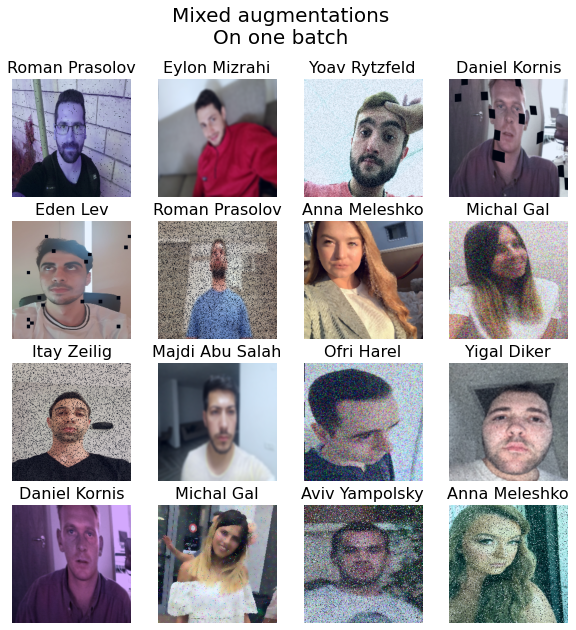

In [0]:
show_aug(seq, 'Mixed augmentations\nOn one batch', 16)

# Blur

I chose to use BLUR augmentations to reduce model dependence on clear and sharp images. Using the selected augments, I can blur the images in several ways and train a more flexible model.

*   GaussianBlur - Augmenter to blur images using gaussian kernels.

*   AverageBlur - Blur an image by computing simple means over  neighbourhoods.

* MedianBlur - Blur an image by computing median values over neighbourhoods.
* BilateralBlur - Blur/Denoise an image using a bilateral filter. 
Bilateral filters blur homogenous and textured areas, while trying to preserve edges.



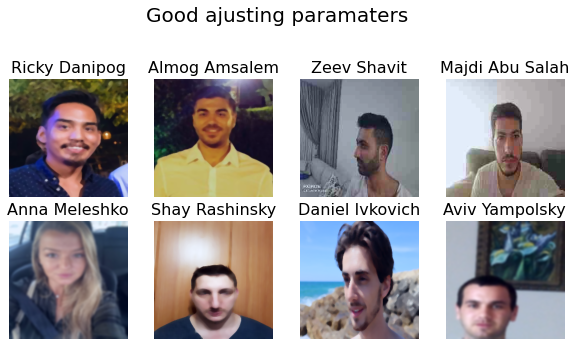

In [0]:
seq_blur = iaa.Sequential([iaa.OneOf([
                                        iaa.GaussianBlur(sigma=2.0),
                                        iaa.AverageBlur(k=(2, 7)),
                                        iaa.JpegCompression(compression=(70, 90)),
                                        iaa.MedianBlur(k=(3, 7)),
                                        iaa.BilateralBlur(d=(3, 10), sigma_color=(10, 250),
                                                            sigma_space=(10, 250))])], random_order=True)

show_aug(seq_blur, 'Good ajusting paramaters')

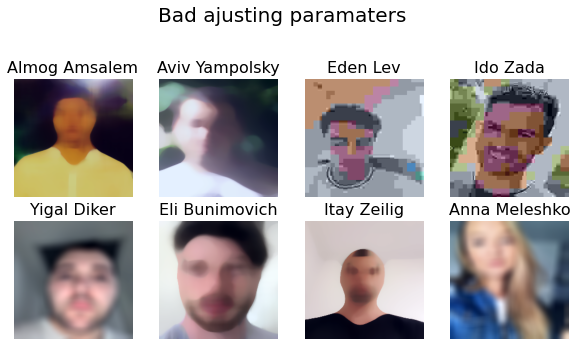

In [0]:
seq_blur = iaa.Sequential([iaa.OneOf([
                                        iaa.GaussianBlur(sigma=7.0),
                                        iaa.AverageBlur(k=(15, 31)),
                                        iaa.JpegCompression(compression=(100, 100)),
                                        iaa.MedianBlur(k=(15, 31)),
                                        iaa.BilateralBlur(d=(15, 31), sigma_color=(10, 250),
                                                            sigma_space=(10, 250))])], random_order=True)

show_aug(seq_blur, 'Bad ajusting paramaters')

# Color


I chose to use Color augmentations to create images with
different colors to train my model to recognize faces from the image regardless of the color of the original image.
Each color hyperparameters needs to be adjusted as it can destroy the images.

*   Add - Add a value to all pixels in an image.

*   AddElementwise - Add values to the pixels of images with possibly different values for neighbouring pixels.

* Multiply - Multiply all pixels in an image with a specific value, thereby making the image darker or brighter.
* MultiplyElementwise - Multiply values of pixels with possibly different values for neighbouring pixels, making each pixel darker or brighter.
* ChannelShuffle - Randomize the order of channels in input images.

* Invert - Augmenter that inverts all values in images




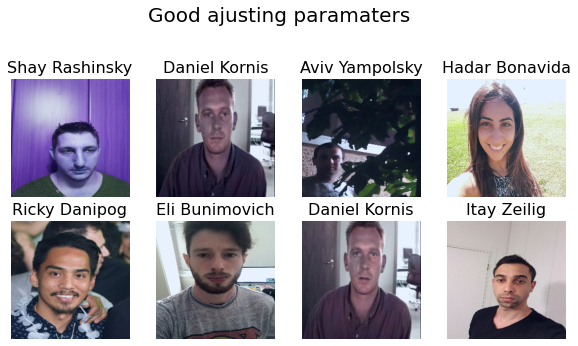

In [0]:
seq_color = iaa.Sequential([iaa.OneOf([
                                           iaa.Add((-40, 40)),
                                           iaa.Add((-40, 40), per_channel=0.5),
                                           iaa.ChannelShuffle(0.35),
                                           iaa.Multiply((0.5, 1.5)),
                                           iaa.Multiply((0.5, 1.5), per_channel=0.5),
                                           iaa.MultiplyElementwise((0.5, 1.5)),
                                           iaa.Invert(0.5),
                                           iaa.Invert(0.25, per_channel=0.5)])], random_order=True)

show_aug(seq_color, 'Good ajusting paramaters')

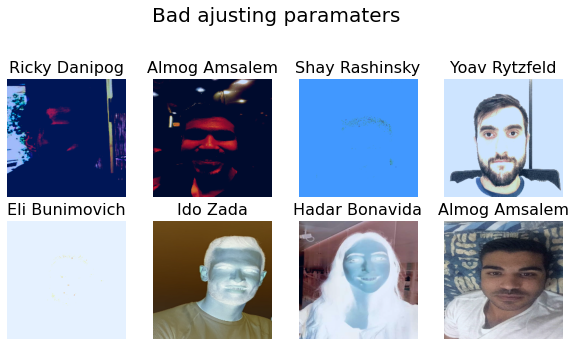

In [0]:
seq_color = iaa.Sequential([iaa.OneOf([
                                           iaa.Add((-255, 255)),
                                           iaa.Add((-255, 255), per_channel=0.5),
                                           iaa.Multiply((0.9, 100)),
                                           iaa.Multiply((0.9, 100), per_channel=0.5),
                                           iaa.MultiplyElementwise((0.5, 1.5)),
                                           iaa.Invert(0.9),
                                           iaa.Invert(0.9, per_channel=0.5)])], random_order=True)

show_aug(seq_color, 'Bad ajusting paramaters')

# Noise
I chose to use noise augmentations because in face recognition model training, sometimes features are not necessarily associated with face recognition. By adding noise, I can allow the model to learn the relevant features. If I add too much noise on the other hand, the picture will be destroyed.

*   AddElementwise - Add values to the pixels of images with possibly different values for neighbouring pixels.

*   AdditiveGaussianNoise - Add noise sampled from gaussian distributions elementwise to images.

* AdditiveLaplaceNoise - Add noise sampled from laplace distributions elementwise to images. The laplace distribution is similar to the gaussian distribution, but puts more weight on the long tail. Hence, this noise will add more outliers (very high/low values). It is somewhere between gaussian noise and salt and pepper noise.

* AdditivePoissonNoise -Add noise sampled from poisson distributions elementwise to images. Poisson noise is comparable to gaussian noise, as e.g. generated via AdditiveGaussianNoise. As poisson distributions produce only positive numbers, the sign of the sampled values are here randomly flipped.

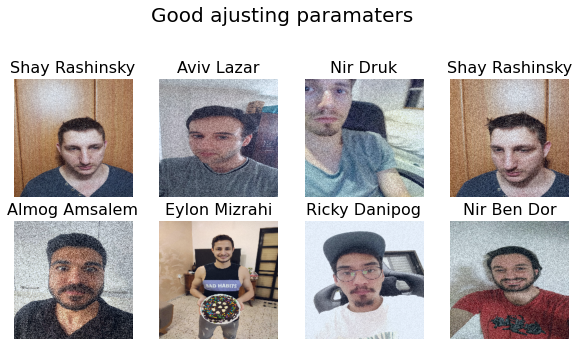

In [0]:
seq_noise = iaa.Sequential([iaa.OneOf([
                                           iaa.AddElementwise((-40, 40)),
                                           iaa.AddElementwise((-40, 40), per_channel=0.5),
                                           iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                                           iaa.AdditiveGaussianNoise(scale=0.2*255, per_channel=True),
                                           iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255)),
                                           iaa.AdditiveLaplaceNoise(scale=0.2*255, per_channel=True),
                                           iaa.AdditivePoissonNoise(lam=(0, 40)),
                                           iaa.AdditivePoissonNoise(lam=40, per_channel=True)])], random_order=True)

show_aug(seq_noise, 'Good ajusting paramaters')

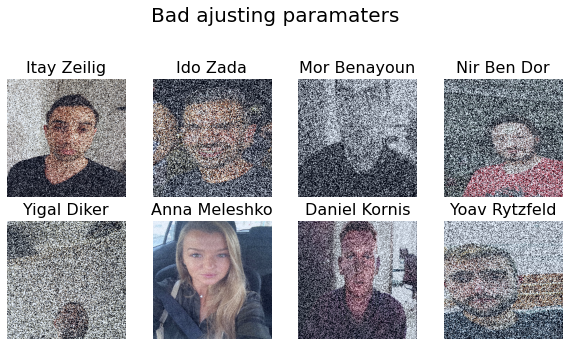

In [0]:
seq_noise = iaa.Sequential([iaa.OneOf([
                                           iaa.AddElementwise((-255, 255)),
                                           iaa.AddElementwise((-255, 255), per_channel=0.5),
                                           iaa.AdditiveGaussianNoise(scale=(0, 255)),
                                           iaa.AdditiveGaussianNoise(scale=(0, 255), per_channel=True),
                                           iaa.AdditiveLaplaceNoise(scale=(0, 255)),
                                           iaa.AdditiveLaplaceNoise(scale=(0, 255), per_channel=True),
                                           iaa.AdditivePoissonNoise(lam=(0, 255)),
                                           iaa.AdditivePoissonNoise(lam=(0, 255), per_channel=True)
                                           ])], random_order=True)

show_aug(seq_noise, 'Bad ajusting paramaters')

# Omitted

Similar to noise augmentations, omission augmentations contribute to model training for finding the strongest features. When I omit elements from the image, I reduce the amount of features and weight the rest at higher weights. Determining the hyperparameters for omission in a careless way will reduce too many parts of the image and even the whole.

*   Dropout - Augmenter that sets a certain fraction of pixels in images to zero.

*   CoarseDropout - Augmenter that sets rectangular areas within images to zero.
* ReplaceElementwise - Replace pixels in an image with new values.
* SaltAndPepper - Replace pixels in images with salt/pepper noise (white/black-ish colors).

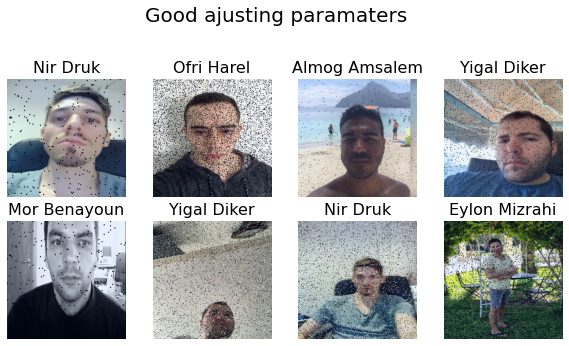

In [0]:
seq_omitted = iaa.Sequential([iaa.OneOf([
                                        iaa.Dropout(p=(0, 0.2)),
                                        iaa.Dropout(p=(0, 0.2), per_channel=0.5),
                                        iaa.CoarseDropout(0.02, size_percent=0.5),
                                        iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),
                                        iaa.CoarseDropout(0.02, size_percent=0.15, per_channel=0.5),
                                        iaa.ReplaceElementwise(0.1, [0, 255]),
                                        iaa.ReplaceElementwise(0.1, [0, 255], per_channel=0.5),
                                        iaa.SaltAndPepper(0.1)])], random_order=True)

show_aug(seq_omitted, 'Good ajusting paramaters')

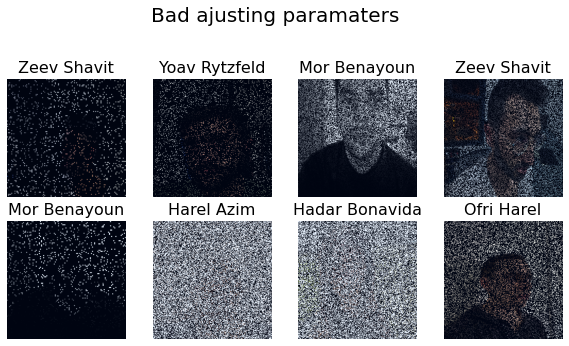

In [0]:
seq_omitted = iaa.Sequential([iaa.OneOf([
                                        iaa.Dropout(p=(0.5, 1)),
                                        iaa.Dropout(p=(0.5, 1), per_channel=0.5),
                                        iaa.CoarseDropout(0.9, size_percent=0.5),
                                        iaa.CoarseDropout((0.5, 0.9), size_percent=(0.02, 0.25)),
                                        iaa.CoarseDropout(0.9, size_percent=0.15, per_channel=0.5),
                                        iaa.ReplaceElementwise(0.9, [0, 255]),
                                        iaa.ReplaceElementwise(0.9, [0, 255], per_channel=0.5),
                                        iaa.SaltAndPepper(0.9)])], random_order=True)

show_aug(seq_omitted, 'Bad ajusting paramaters')

# Geometric

Similar to blur augments, using geometric transforms allows the model to recognize facial features even if the face is not "ideal" for example: lying, smeared or tilted. The use of geometric augments will help the model identify facial features more comprehensively. It is important to pay attention to the parameters, too large a placement will destroy the image
* Affine - Augmenter to apply affine transformations to images.
    * Scale images to a value of k to k% of their original size, but do this independently per axis
    * Shear images by -k to k degrees
* ElasticTransformation - Transform images by moving pixels locally around using displacement fields. The augmenter has the parameters alpha and sigma. alpha controls the strength of the displacement: higher values mean that pixels are moved further. sigma controls the smoothness of the displacement: higher values lead to smoother patterns – as if the image was below water – while low values will cause indivdual pixels to be moved very differently from their neighbours, leading to noisy and pixelated images.
* PiecewiseAffine - Apply affine transformations that differ between local neighbourhoods. This augmenter places a regular grid of points on an image and randomly moves the neighbourhood of these point around via affine transformations. This leads to local distortions.
* PerspectiveTransform - Apply random four point perspective transformations to images. Each of the four points is placed on the image using a random distance from its respective corner. The distance is sampled from a normal distribution. As a result, most transformations don’t change the image very much, while some “focus” on polygons far inside the image.The results of this augmenter have some similarity with Crop.
* Rot90 - Rotate all images by 90, 180 or 270 degrees. Resize these images afterwards to keep the size that they had before augmentation. This may cause the images to look distorted.

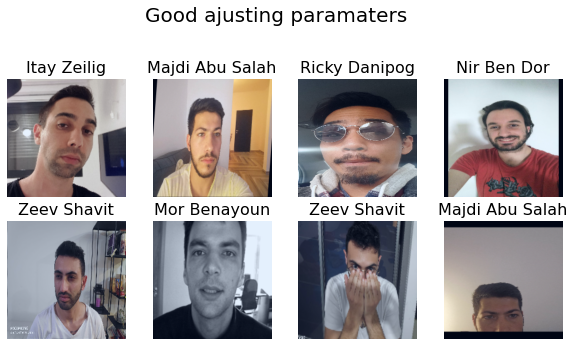

In [0]:
seq_geo = iaa.Sequential([iaa.OneOf([
                                           iaa.Affine(scale={"x": (0.5, 1.5), "y": (0.5, 1.5)}),
                                           iaa.Affine(shear=(-10, 10)),
                                           iaa.ElasticTransformation(alpha=(0, 10), sigma=10),
                                           iaa.PiecewiseAffine(scale=(0.01, 0.05)),
                                           iaa.PerspectiveTransform(scale=(0.01, 0.15), keep_size=True),
                                           iaa.Rot90((1, 3))])], random_order=True)

show_aug(seq_geo, 'Good ajusting paramaters')

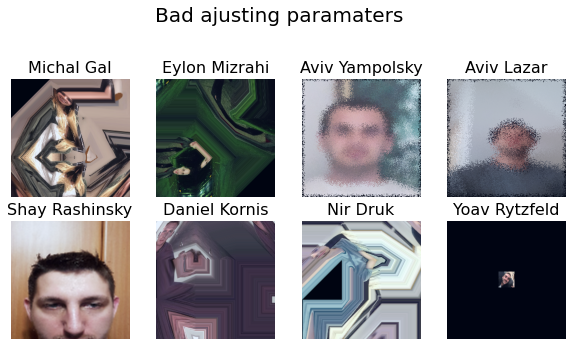

In [0]:
seq_geo = iaa.Sequential([iaa.OneOf([
                                           iaa.Affine(scale=(0.01, 1.99)),
                                           iaa.Affine(shear=(-180, 180)),
                                           iaa.ElasticTransformation(alpha=(5, 10), sigma=0.25),
                                           iaa.PiecewiseAffine(scale=(1.01, 3.05)),
                                           iaa.PerspectiveTransform(scale=(0.15, 0.5), keep_size=True)])], random_order=True)

show_aug(seq_geo, 'Bad ajusting paramaters')

# Part 1 summary
In this part of the assignment I was required to prepare a dataset for all the student pictures in the course. I used the PYTOURCH DATASET. The total amount of images is 557, this amount is not enough to train a model. To generate a large amount of images, I need to apply image augmentation techniques. To do this, I used the IMGAUG library which provides ready-to-use augments. The types of augmentations selected can be subdivided so that each augmentation group changes a specific detail of the image, thus obtaining a slightly different image from the original image.
As part of my work, I used augmentations: blurring, changing colors, adding and dropping pixels, and geometric augments that move pixels throughout the image space.
When using augmentations, I ran into the problem of adjusting the hyperparameters for the desired augmentation to get a picture that the model could learn from. Selecting a small hyperparameter will not change the image relative to the source image, while selecting a high hyperparameter will destroy the image and will not be usable.
After building the dataset and selecting the augments, I was required to use the tool that I could work through with the images. I used the PYTOURCH DATALOADER which provides an effective tool for pulling BATCHS from the dataset.

In [0]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml
!wget https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml

--2020-05-30 15:43:46--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2020-05-30 15:43:47 (16.6 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]

--2020-05-30 15:43:49--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:44

In [0]:
class face_detector():
    def __init__(self,
                 haarcascade = "haarcascade_frontalface_alt2.xml",
                 LBFmodel = 'lbfmodel.yaml'):
        self.detector = cv2.CascadeClassifier(haarcascade)
        self.landmark_detector  = cv2.face.createFacemarkLBF()
        self.landmark_detector.loadModel(LBFmodel)
    
    def get_face_landmarks(self, original):
        img = original.copy()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img, largest_rect = self.find_largest_rectangle(img)
        rv_landmark = []
        _, landmarks = self.landmark_detector.fit(gray, largest_rect)
        for landmark in landmarks:
            for x, y in landmark[0]:
                cv2.circle(img, (x, y), 5, (0, 255, 0), -1)
                rv_landmark.append((int(x),int(y)))
        return img, rv_landmark

    def find_largest_rectangle(self, img):
        ''' The function check if face detection found several faces and return the largest
        '''
        faces = self.detector.detectMultiScale(img, 1.1, 5)
        largest_rect = np.argmax([w*2 + h*2 for _, _, w, h in faces])
        largest_rect = np.array([faces[largest_rect]], np.int32)
        a, b, a_w, b_h = largest_rect[0]

        cv2.rectangle(img, (a, b), (a+a_w, b+b_h), (0, 255, 0), 10)
        return img, largest_rect




In [0]:
def extract_face(gray, points):
    points = np.array(points, np.int32)
    original = gray.copy()
    if len(gray.shape) == 3:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)  
    mask = np.zeros_like(gray)
    convexhull_points = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull_points, 255)
    face = cv2.bitwise_and(original, original, mask=mask)
    return face, convexhull_points

def indexes2coordinates(points, trinagle_indexes):
    pt1 = points[trinagle_indexes[0]]
    pt2 = points[trinagle_indexes[1]]
    pt3 = points[trinagle_indexes[2]]
    return pt1, pt2, pt3

def extract_index(points, pt):
    index_pt = np.where((points == pt).all(axis=1))
    index = None
    for n in index_pt[0]:
        index = n 
        break
    return index

In [0]:
def mini_triangle(landmarks, indexes_triangle, img, triangle_face, draw_triangles=False):
    pt1, pt2, pt3 = indexes2coordinates(landmarks, indexes_triangle)
    triangle = np.array([
                        (pt1[0], pt1[1]),
                        (pt2[0], pt2[1]),
                        (pt3[0], pt3[1])], np.int32)
    
    (x, y, w, h) = cv2.boundingRect(triangle)
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_mask = np.zeros((h, w), np.uint8)
    person_points = np.array([
                    [pt1[0] - x, pt1[1] - y],
                    [pt2[0] - x, pt2[1] - y],
                    [pt3[0] - x, pt3[1] - y]], np.int32)
    cv2.fillConvexPoly(cropped_mask, person_points, 255)
    if draw_triangles:
        cv2.line(triangle_face, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (255, 255, 255), 2)
        cv2.line(triangle_face, (pt2[0], pt2[1]), (pt3[0], pt3[1]), (255, 255, 255), 2)
        cv2.line(triangle_face, (pt3[0], pt3[1]), (pt1[0], pt1[1]), (255, 255, 255), 2)
    return person_points, cropped_triangle, cropped_mask, (x, y, w, h)


In [0]:

def transform_face_to_new_position(person1, person2, indexes_triangles, person1_landmarks, person2_landmarks):
    person1_org = person1.copy()
    person2_org = person2.copy()
    new_position = np.zeros_like(person2, np.uint8)

    for trd in indexes_triangles:
        person1_points, cropped_triangle, _, _= mini_triangle(person1_landmarks, trd, person1, person1_org)
        person2_points, _, mask, p = mini_triangle(person2_landmarks, trd, person2, person2_org)
        (x, y, w, h) = p
        # Warp triangles
        person1_points = np.float32(person1_points)
        person2_points = np.float32(person2_points)
        M = cv2.getAffineTransform(person1_points, person2_points)
        warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask)
            
        # Reconstructing destination face
        rectangle_area = new_position[y: y + h, x: x + w]
        rectangle_area_gray = cv2.cvtColor(rectangle_area, cv2.COLOR_RGB2GRAY)
        # extrac trinagle from mask
        _, mask_triangles_designed = cv2.threshold(rectangle_area_gray,
                                                   1, 255, cv2.THRESH_BINARY_INV)
        # run over empty balck spaces
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle,
                                          mask=mask_triangles_designed)
        rectangle_area = cv2.add(rectangle_area, warped_triangle)
        new_position[y: y + h, x: x + w] = rectangle_area
    return new_position


In [0]:

def draw_triangles(image, points, draw_triangles=False):
    img = image.copy()
    np_points = np.array(points,dtype=np.int32)
    b_rect = cv2.boundingRect(np_points)
    subdiv = cv2.Subdiv2D(b_rect)
    subdiv.insert(points)
    triangles = np.array(subdiv.getTriangleList(), np.int32)
    triangles_indexes = []
    for point in triangles:
        pt1 = (point[0], point[1])
        pt2 = (point[2], point[3])
        pt3 = (point[4], point[5])

        index_pt1 = extract_index(np_points, pt1)
        index_pt2 = extract_index(np_points, pt2)
        index_pt3 = extract_index(np_points, pt3)
        
        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangles_indexes.append([index_pt1, index_pt2, index_pt3])
            if draw_triangles:
                cv2.line(img, (point[0], point[1]), (point[2], point[3]), (0, 255, 255), 4)
                cv2.line(img, (point[2], point[3]), (point[4], point[5]), (0, 255, 255), 4)
                cv2.line(img, (point[4], point[5]), (point[0], point[1]), (0, 255, 255), 4)

    triangles_indexes = np.array(triangles_indexes, np.int32)
    return img, triangles_indexes


In [0]:

def swap_faces(person1, person2, face_landmarks1, face_landmarks2):
    person1_face, _ = extract_face(person1, face_landmarks1)
    person1_with_triangles, indexes_triangles = draw_triangles(person1_face, face_landmarks1)
    person2_gray = cv2.cvtColor(person2, cv2.COLOR_RGB2GRAY)
    _, person2_convexhull_points = extract_face(person2, face_landmarks2)
    new_position = transform_face_to_new_position(person1, person2,
                                                  indexes_triangles, face_landmarks1,
                                                  face_landmarks2)
    
    # Face swapped (putting 1st face into 2nd face)
    person2_face_mask = np.zeros_like(person2_gray)
    person2_head_mask = cv2.fillConvexPoly(person2_face_mask, person2_convexhull_points, 255)
    person2_face_mask = cv2.bitwise_not(person2_head_mask)
    person2_head_noface = cv2.bitwise_and(person2, person2, mask=person2_face_mask)
    befor_adjustment = cv2.add(person2_head_noface, new_position)

    (x, y, w, h) = cv2.boundingRect(person2_convexhull_points)
    center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
    result = cv2.seamlessClone(befor_adjustment, person2, person2_head_mask, center_face2, cv2.NORMAL_CLONE)

    return befor_adjustment, result




In [0]:
def preprocessing(id, size=1024):
    person = cv2.imread(train_paths[id])
    person = cv2.cvtColor(person, cv2.COLOR_BGR2RGB)
    person = cv2.resize(person, (size, size))
    return person

def find_valid_faces():
    fd = face_detector()
    remmber = -1
    for i in range(2):
        while True:
            index = np.random.randint(len(train_paths))
            person = preprocessing(index)
            if remmber != index:
                try:
                    afterlandmarks, landmarks = fd.get_face_landmarks(person)
                    remmber = index
                    l = (person, afterlandmarks, landmarks)
                    break
                except:
                    pass
        if i % 2: 
            studet1 = l
        else:
            studet2 = l
    return studet1, studet2

def show_result(images_list, titles, row=2, col=2):
    plt.figure(figsize=[10, 10])
    for i, (img, title) in enumerate(zip(images_list, titles)):
        plt.subplot(row, col, i+1)
        plt.imshow(img)
        plt.title(title, fontsize=18)
        plt.axis('off')
    plt.show()





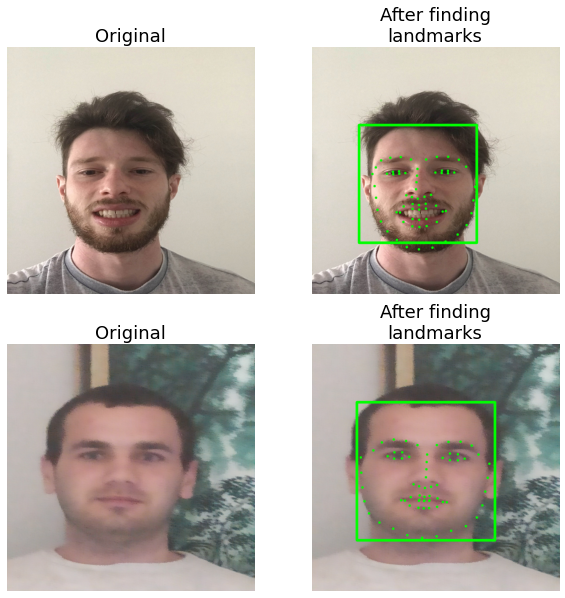

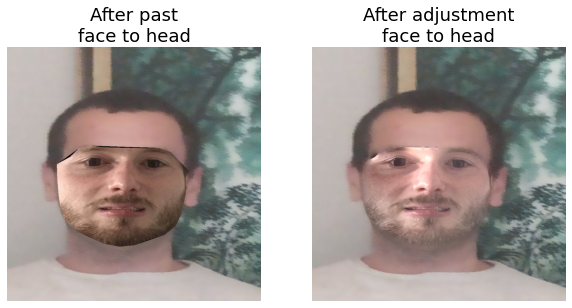

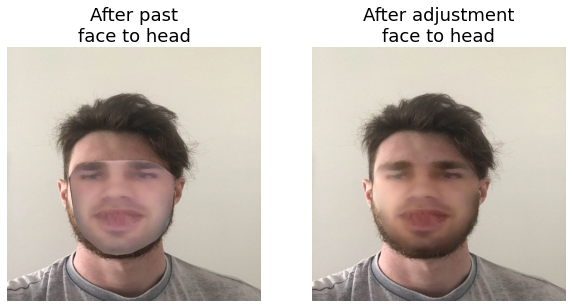

In [84]:
person1, person2 = find_valid_faces()
images_list=[person1[0], person1[1], person2[0], person2[1]]
titles = ['Original', 'After finding\nlandmarks', 'Original', 'After finding\nlandmarks']
show_result(images_list, titles)


befor_adjust, result = swap_faces(person1[0], person2[0], person1[2], person2[2])
images_list = [befor_adjust, result]
titles = ['After past\nface to head', 'After adjustment\nface to head']
show_result(images_list, titles, row=1, col=2)

befor_adjust, result = swap_faces(person2[0], person1[0], person2[2], person1[2])
images_list = [befor_adjust, result]
show_result(images_list, titles, row=1, col=2)



# Summary part 2 Faces swapping
To swap between two faces i had to split the work for several steps.
## step 1: finding and extractind landmarks from face.
 first, I have to find the faces and from each face extract landmarks.
for this step, I create a class for finding and extract those features.
OpenCV has a built-in detectors for finding faces and landmarks extraction

functions used in this step:

Class face_detector

def preprocessing()

def find_valid_faces()



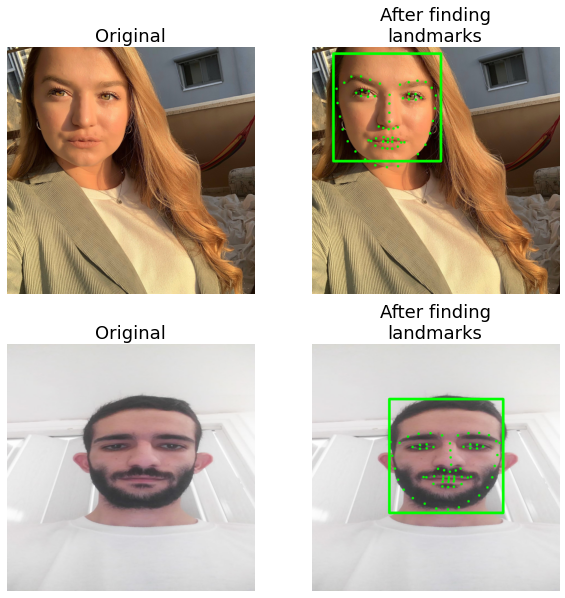

In [0]:
# Example for step 1
person1, person2 = find_valid_faces()
images_list=[person1[0], person1[1], person2[0], person2[1]]
titles = ['Original', 'After finding\nlandmarks', 'Original', 'After finding\nlandmarks']
show_result(images_list, titles)


## step 2: create Delaunay Triangulation
To try swapping full rectangle face with another one will damage the ratio in the face and will destroy him. 
To handle this problem I read about Delaunay Triangulation. With this technique, I'll split the first face into indexes triangles and then I swap the triangles in the corresponding region.
This will minimize the damage to the face ratio.

functions that used in this step:

* def extract_face(gray, points)

    * gray - gray scale image

    * points - array of landmarks points

the function extracts a face (convex hull) from a given set of landmarks points.

* def draw_triangles(img, points, draw_triangles=False)
    * img - original image
    * points - array of landmarks points
    * draw_triangles - if True the function will draw lines on the image.

The function draw lines between 3 indexes for creating Delaunay triangles.

* def extract_index(points, pt)
    *  points - array of landmarks points
    *  pt - landmark point

for being able to swap between triangles first I need to encode each landmark point to index. Without it, I couldn't find the relevant triangle on the second face. 




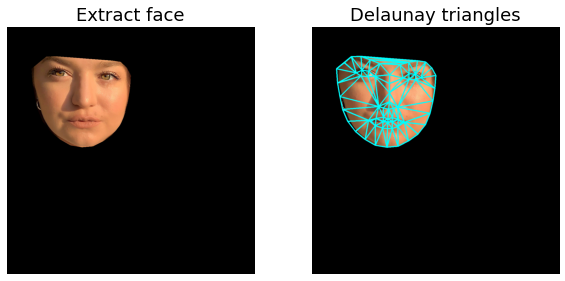

In [0]:
person1_face, _ = extract_face(person1[0], person1[2])
person1_with_triangles, _ = draw_triangles(person1_face, person1[2], True)
person2_face, _ = extract_face(person2[0], person2[2])
person2_with_triangles, indexes_triangles = draw_triangles(person2_face, person2[2], True)

images_list=[person1_face, person1_with_triangles]
titles = ['Extract face', 'Delaunay triangles']
show_result(images_list, titles)




# Step 3: Transform the face of person 1 to position and shape of person2
Once I find the Delawani triangles of the first face landmarks point and give each point index, I'll look for the triangles in the second face. Then I will index each face landmark point. after this, I have to loop over all of the triangles from the first face, look for the relevant triangle (by index) in the second face, make an AffineTransform from the shape of the first triangle to the shape of the second triangle.

functions that used in this step:
* def transform_face_to_new_position(person1, person2, indexes_triangles, person1_landmarks, person2_landmarks)
 
    * person1\person2 - original image of each student
    * indexes_triangles - list of triangles indexes of first person
    * person1_landmarks\ person2_landmarks - landmarks list of each person

the function loop over all the triangles and create the first person face in the ration and coordiate of the second person

* def mini_triangle(landmarks, indexes_triangle, img, triangle_face, draw_triangles=False)
    * landmarks -  array of landmarks points
    * indexes_triangle - 3 indexes which create spcipic triangle
    * img - original image
    * triangle_face - image for draing trigangles on it

The function will take triangle indexes and trasform it to corrispondent triangle shape of person 2




 



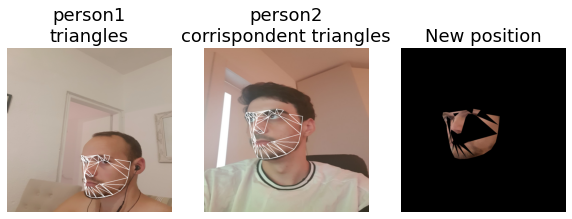

In [0]:

def transform_face_to_new_position1(person1, person2, indexes_triangles, person1_landmarks, person2_landmarks):
    stop = 0
    person1_org = person1.copy()
    person2_org = person2.copy()
    new_position = np.zeros_like(person2, np.uint8)

    for trd in indexes_triangles:
        # Person 1:
        # person_points, cropped_triangle, cropped_mask, (x, y, w, h)
        person1_points, cropped_triangle1, mask1, _= mini_triangle(person1_landmarks, trd, person1, person1_org, True)
        person2_points, cropped_triangle2, mask2, p = mini_triangle(person2_landmarks, trd, person2, person2_org, True)

        (x, y, w, h) = p
        # Warp triangles
        person1_points = np.float32(person1_points)
        person2_points = np.float32(person2_points)
        M = cv2.getAffineTransform(person1_points, person2_points)
        warped_triangle = cv2.warpAffine(cropped_triangle1, M, (w, h))
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask2)
        
        # Reconstructing destination face
        rectangle_area = new_position[y: y + h, x: x + w]
        rectangle_area_gray = cv2.cvtColor(rectangle_area, cv2.COLOR_RGB2GRAY)
        _, mask_triangles_designed = cv2.threshold(rectangle_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
        warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)
        rectangle_area = cv2.add(rectangle_area, warped_triangle)
        new_position[y: y + h, x: x + w] = rectangle_area

        if stop == 50:
            images_list = [person1_org, person2_org, new_position]
            titles = ['person1\ntriangles', 'person2\ncorrispondent triangles', 'New position']
            show_result(images_list, titles, col=3)
            break
        stop+=1

    # return img2_new_face
transform_face_to_new_position1(person1[0], person2[0], indexes_triangles, person1[2], person2[2])

# Step 4: 
At the end of the previous step, the first man's face was moved to the second man's position and shape. Each triangle from first was changed to its suitable shape in the second face.
At this step, I have to remove the second man's face and replace it with the first man's face (input from the previous step).
adjust the paste to look more natural.

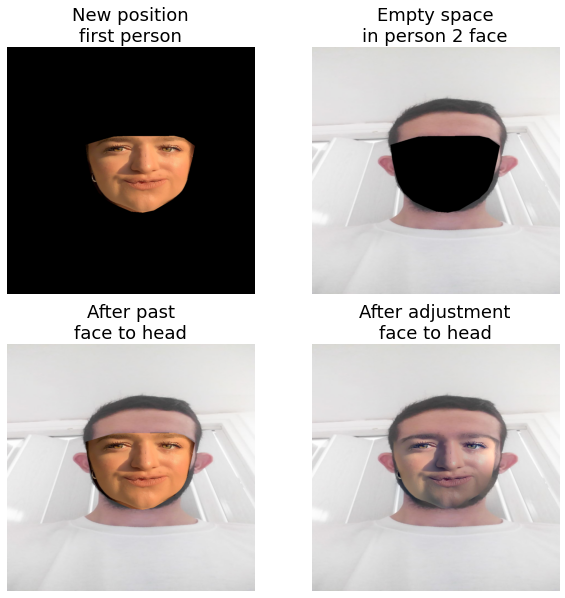

In [0]:
new_position = transform_face_to_new_position(person1[0], person2[0], indexes_triangles, person1[2], person2[2])

person2_gray = cv2.cvtColor(person2[0], cv2.COLOR_RGB2GRAY)
_, person2_convexhull_points = extract_face(person2[0], person2[2])

person2_face_mask = np.zeros_like(person2_gray)
person2_head_mask = cv2.fillConvexPoly(person2_face_mask, person2_convexhull_points, 255)
person2_face_mask = cv2.bitwise_not(person2_head_mask)
person2_head_noface = cv2.bitwise_and(person2[0], person2[0], mask=person2_face_mask)
befor_adjustment = cv2.add(person2_head_noface, new_position)

(x, y, w, h) = cv2.boundingRect(person2_convexhull_points)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
result = cv2.seamlessClone(befor_adjustment, person2[0], person2_head_mask, center_face2, cv2.NORMAL_CLONE)

images_list = [new_position, person2_head_noface, befor_adjustment, result]
titles = ['New position\nfirst person face', 'Empty space\nin person 2 face', 'After past\nface to head', 'After adjustment\nface to head']
show_result(images_list, titles)


# matirals
[face detection and landmark extraction](https://medium.com/analytics-vidhya/facial-landmarks-and-face-detection-in-python-with-opencv-73979391f30e)

[Facial swap tutorial series](https://www.youtube.com/watch?v=dK-KxuPi768)

another technique for landmarks extraction:
Not implemented in this work

[another technique](https://www.learnopencv.com/convex-hull-using-opencv-in-python-and-c/)